In [1]:
import numpy as np
import cv2 
import glob
import random
from pathlib import Path
from sklearn.model_selection import train_test_split
import shutil
import os
import plistlib
from skimage.draw import *
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

c:\Users\rainm\miniconda3\envs\pytorch2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def crop(img):

    blur = cv2.GaussianBlur(img,(5,5),0)
    _, breast_mask = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    cnts, _ = cv2.findContours(breast_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key = cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)

    return img[y:y+h, x:x+w], breast_mask[y:y+h, x:x+w]

In [3]:
def clahe(img, clip):
    clahe = cv2.createCLAHE(clipLimit=clip)
    cl = clahe.apply(np.array(img*255, dtype=np.uint8))
    return cl

In [4]:
def truncation_normalization(img, mask):
    
    Pmin = np.percentile(img[mask!=0], 5)
    Pmax = np.percentile(img[mask!=0], 99)
    truncated = np.clip(img,Pmin, Pmax)  
    normalized = (truncated - Pmin)/(Pmax - Pmin)
    normalized[mask==0]=0
    return normalized

In [12]:
def synthetized_images(image_path):
    image = Image.open(image_path)
    image = np.array(image)

    breast, mask = crop(image)
    normalized = truncation_normalization(breast, mask)
    return normalized
    """ cl1 = clahe(normalized, 1.0)
    cl2 = clahe(normalized, 2.0)

    synthetized = cv2.merge((np.array(normalized*255, dtype=np.uint8),cl1,cl2))
    return synthetized """

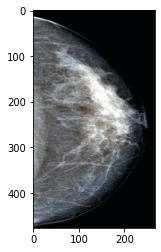

In [13]:
synthetized = synthetized_images("../data/view_dset_01_splitted/cc_splitted/train/1/106_76321767.png")
plt.imshow(synthetized, cmap="gray")

In [16]:
cc_train_0_path = "../data/view_dset_01_splitted/cc_splitted/train/0/"
cc_train_1_path = "../data/view_dset_01_splitted/cc_splitted/train/1/"

benign_paths = []
for name in os.listdir(cc_train_0_path):
    benign_paths.append((cc_train_0_path + name, name))

malignant_paths = []
for name in os.listdir(cc_train_1_path):
    malignant_paths.append((cc_train_1_path + name, name))

len(benign_paths), len(malignant_paths)

(20959, 452)

In [17]:
cc_test_0_path = "../data/view_dset_01_splitted/cc_splitted/test/0/"
cc_test_1_path = "../data/view_dset_01_splitted/cc_splitted/test/1/"

benign_paths = []
for name in os.listdir(cc_test_0_path):
    benign_paths.append((cc_test_0_path + name, name))

malignant_paths = []
for name in os.listdir(cc_test_1_path):
    malignant_paths.append((cc_test_1_path + name, name))

len(benign_paths), len(malignant_paths)

(5240, 114)

In [20]:
cc_train_0_prep_path = "../data/view_dset_01_splitted/cc_splitted/train_prep/0/"
cc_train_1_prep_path = "../data/view_dset_01_splitted/cc_splitted/train_prep/1/"

if not os.path.exists(cc_train_0_prep_path):
    os.makedirs(cc_train_0_prep_path)

if not os.path.exists(cc_train_1_prep_path):
    os.makedirs(cc_train_1_prep_path)

for path, filename in tqdm(benign_paths):
    preprocessed_img = synthetized_images(path)
    preprocessed_img = cv2.resize(preprocessed_img, (512, 512))
    cv2.imwrite(cc_train_0_prep_path + filename, preprocessed_img)

for path, filename in tqdm(malignant_paths):
    preprocessed_img = synthetized_images(path)
    preprocessed_img = cv2.resize(preprocessed_img, (512, 512))
    cv2.imwrite(cc_train_1_prep_path + filename, preprocessed_img)

100%|██████████| 114/114 [00:01<00:00, 79.42it/s]


In [19]:
cc_test_0_prep_path = "../data/view_dset_01_splitted/cc_splitted/test_prep/0/"
cc_test_1_prep_path = "../data/view_dset_01_splitted/cc_splitted/test_prep/1/"

if not os.path.exists(cc_test_0_prep_path):
    os.makedirs(cc_test_0_prep_path)

if not os.path.exists(cc_train_1_prep_path):
    os.makedirs(cc_train_1_prep_path)

for path, filename in tqdm(benign_paths):
    preprocessed_img = synthetized_images(path)
    preprocessed_img = cv2.resize(preprocessed_img, (512, 512))
    cv2.imwrite(cc_test_0_prep_path + filename, preprocessed_img)

for path, filename in tqdm(malignant_paths):
    preprocessed_img = synthetized_images(path)
    preprocessed_img = cv2.resize(preprocessed_img, (512, 512))
    cv2.imwrite(cc_test_1_prep_path + filename, preprocessed_img)

100%|██████████| 114/114 [00:00<00:00, 179.47it/s]
